In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import zfit
from zfit import z

/home/ryan/Develope/Physics/env/lib/python3.8/site-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


In [3]:
import mplhep as hep

In [4]:
from plotting_meta.plotting_meta import bins, color_cycle, cms_format_fig, Bins

from bff_plotting_tools.make_hists import make_sys, SysHist
from bff_plotting_tools.utils import hist_chi2
from bff_plotting_tools.data_getter import get_data

from bff_signal_model.bff_bck_model import bff_bck_model, sigma, theta, mean

from bff_processor.utils import ratio_plot_template

In [20]:
era = '2017'
df, lumi = get_data(era)
df = df[(df.DiLepMass > bins.calc_bin_range()[0]) & (df.DiLepMass <  bins.calc_bin_range()[1])]
compute_hesse=True
binning_type = 'split'

In [21]:
obs = zfit.Space("x", limits=bins.calc_bin_range())

In [22]:
def fit_lognorm(y, weights, obs, verbose=False):
    lognorm = bff_bck_model(obs, sigma=sigma, theta=theta, mean=mean)

    # load the data
    data = zfit.Data.from_numpy(obs=obs, array=y, weights=weights)
    
    # build the loss
    nll = zfit.loss.UnbinnedNLL(model=lognorm, data=data)

    # minimize
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    lognorm.result = result
    
    # calculate errors
    param_errors = result.hesse()
    
    if verbose: print(result,"\n", param_errors)
    
    return lognorm, data

In [23]:
def fit_region(reg, type_data):
    # get data
    region = df[(df.type==type_data) & (df['{}_nom'.format(reg)]==1)]
    #make data_hist
    y = region.DiLepMass.to_numpy()
    weight = region.Weight.to_numpy()
    hist = make_sys(region, 'DiLepMass', reg)
    # fit data
    ln, data = fit_lognorm(y, weight, obs, verbose=True)
    # make fit hist
    normalization = np.sum(hist.nominal)
    fit = ln.fill_bins(bins, normalization, supersample=1)
    return {"hist":hist, "fit": fit}

In [24]:
def make_plot(reg, reg_dict, label):
    fit, hist = reg_dict['fit'], reg_dict['hist']
    fig, ax, rax = ratio_plot_template(figsize=(10,10))
    hist.make_density_hist().draw(ax, color=color_cycle[3], label=label)
    fit.make_density_hist().draw(ax, color=color_cycle[0], label='Fit', error_scale=0)
    #ratio plot
    hist.calc_ratio(fit.nominal).draw(rax, color=color_cycle[3])
    fit.calc_ratio(fit.nominal).draw(rax, color=color_cycle[0], error_scale=0)
    rax.set_ylim(bottom=0, top=2)
    ax.set_yscale('log')
    ax.set_ylabel('Events per GeV')
    ax.set_xlabel('DiLepMass [GeV]')
    ax.set_ylim(bottom=1e-2, top=1e4)
    ax.legend(title = '{}'.format(reg))
    cms_format_fig(era, ax)
    fig.savefig('fits/abcd/{}_binning_density_{}_{}_{}.png'.format(binning_type, era, reg, label))
    fit_chi2 = hist_chi2(hist, fit, nDOF=4)
    return {'era': era, 'reg': reg, 'bck':np.sum(hist.nominal), 'bck_unc': np.sum(hist.std**2)**.5, 
                      'ABCD mc': np.sum(fit.nominal), 'fit chi2': fit_chi2, 'label': label}

In [25]:
plot_dict_mc = {}
plot_dict = {}
for reg in ['CR10', 'CR13', 'CR14', 'CR20', 'CR23', 'CR24']:
    print(reg)
    plot_dict_mc[reg] = fit_region(reg, "bck")
    plot_dict[reg] = fit_region(reg, "data")
    

CR10
FitResult of
<UnbinnedNLL model=[<zfit.<class 'bff_signal_model.bff_bck_model.bff_bck_model'>  params=[mean, sigma, theta]] data=[<zfit.core.data.Data object at 0x7f309bae7a00>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.4e-05 │ 632.7       │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value    minuit_hesse    at limit
------  -------  --------------  ----------
mean      79.22     +/-     4.8       False
sigma    0.6937     +/-   0.029       False
theta     49.52     +/-      19       False 
 {<zfit.Parameter 'mean' floating=True value=79.22>: {'error': 4.798242261177806, 'cl': 0.68268949}, <zfit.Parameter 'sigma' floating=True value=0.6937>: {'error': 0.029217029662566098, 'cl'

CR10
CR13
CR14
CR20
CR23
CR24


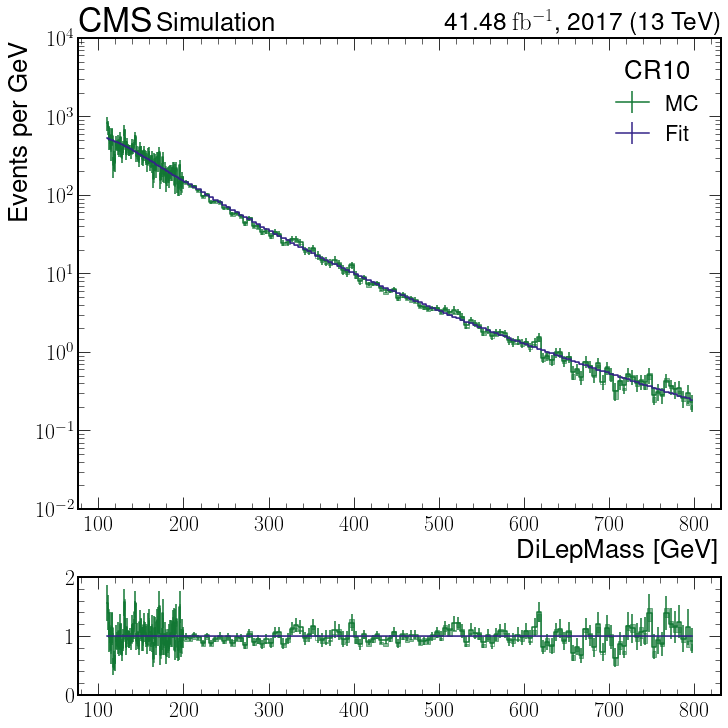

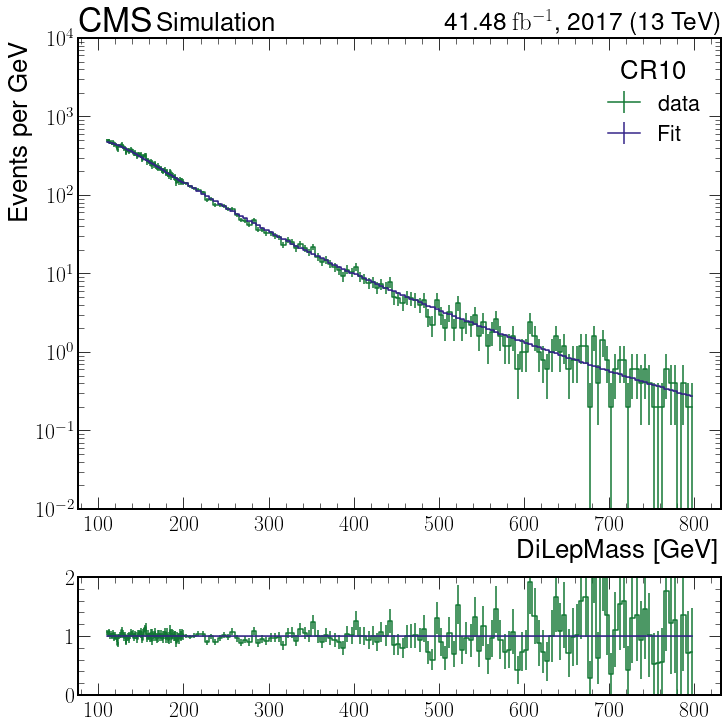

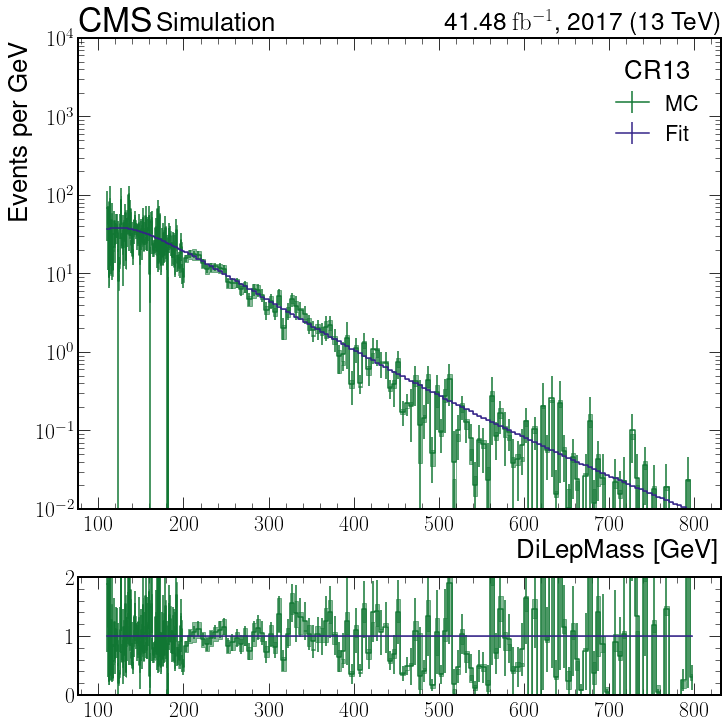

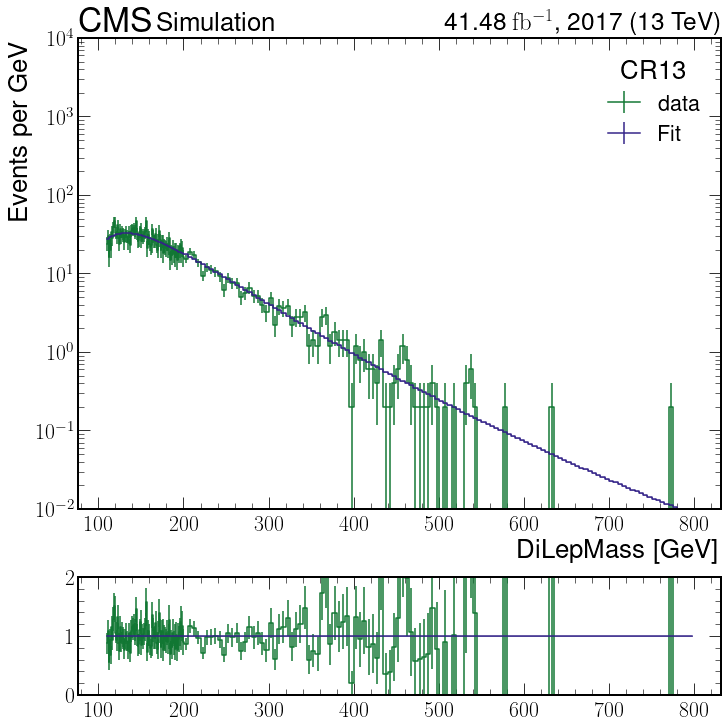

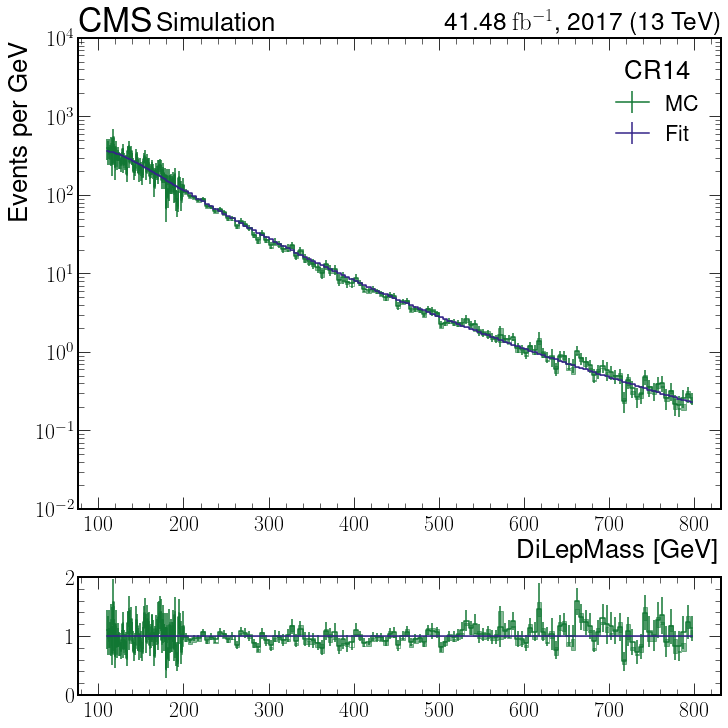

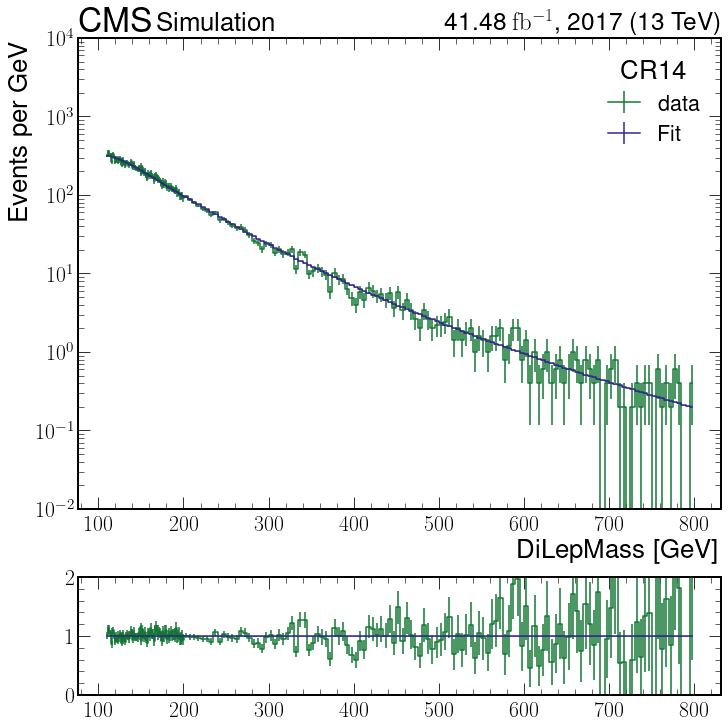

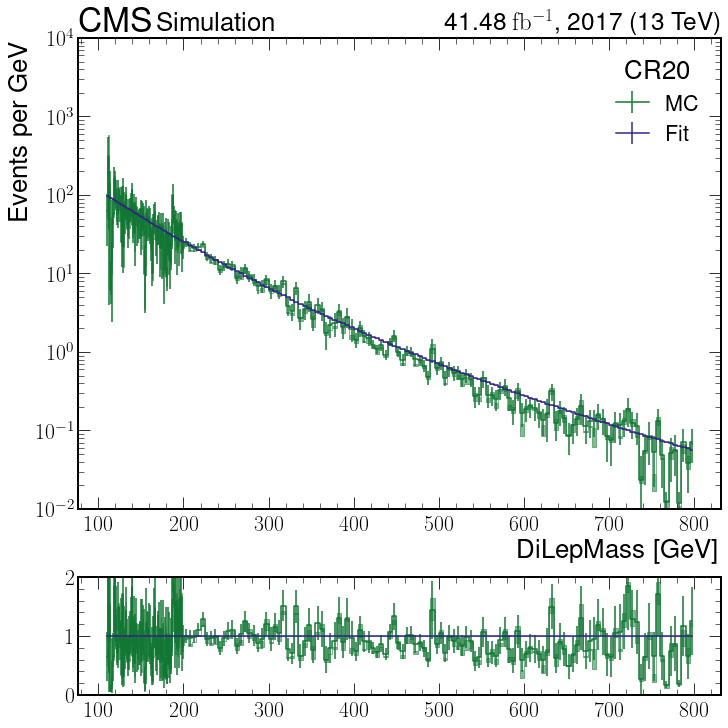

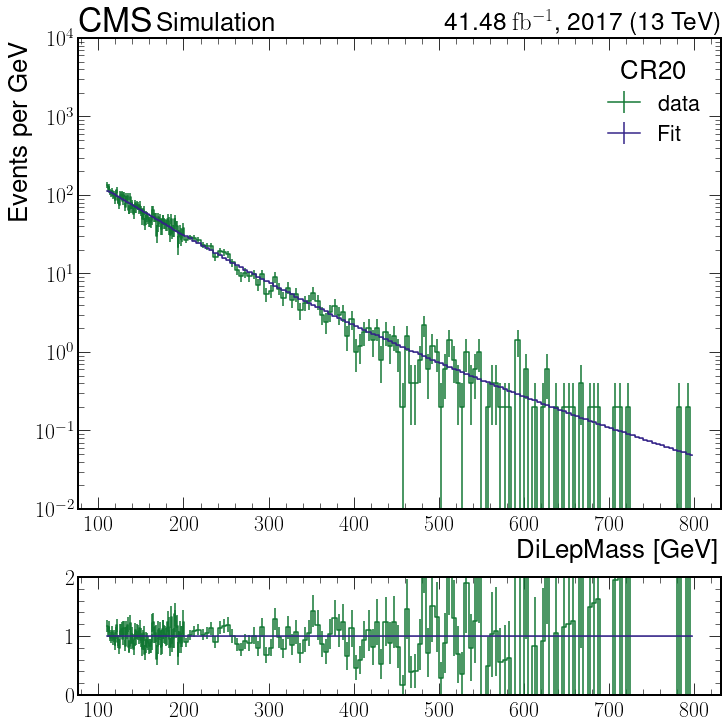

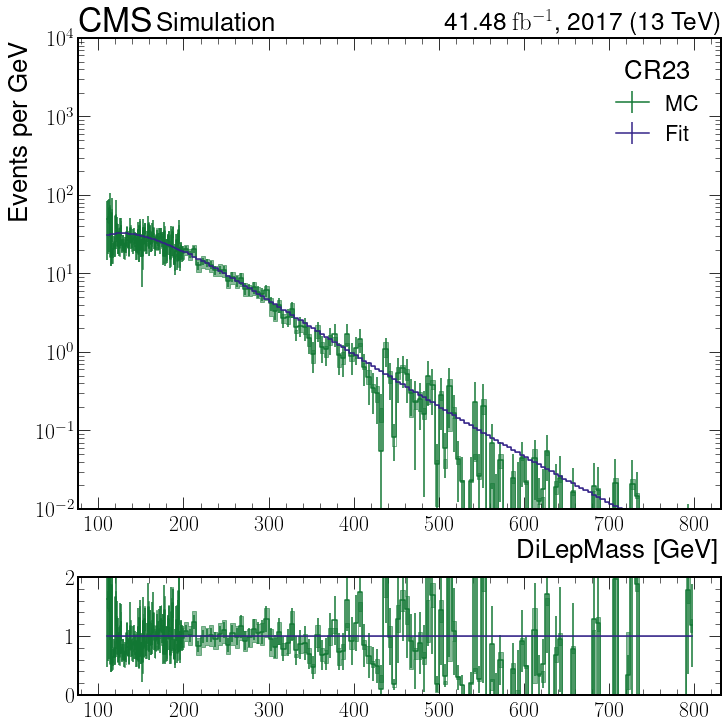

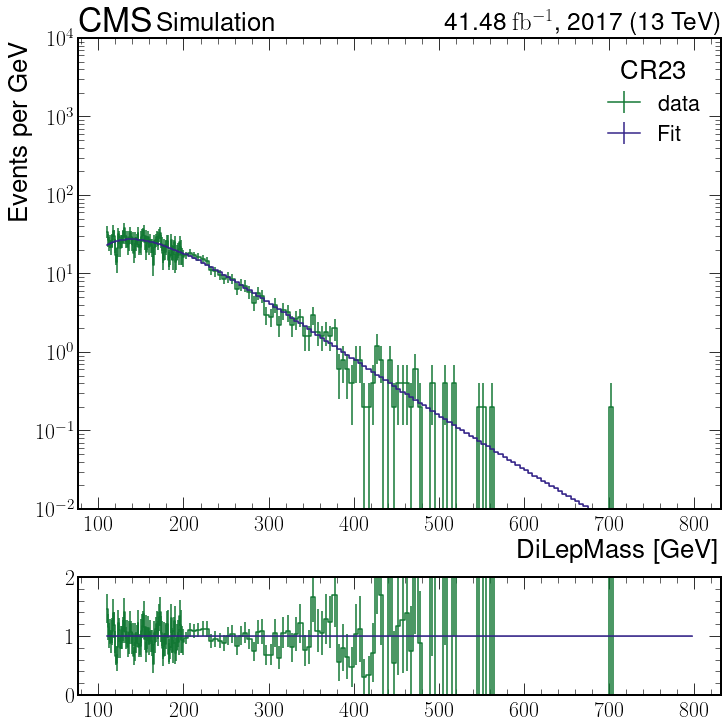

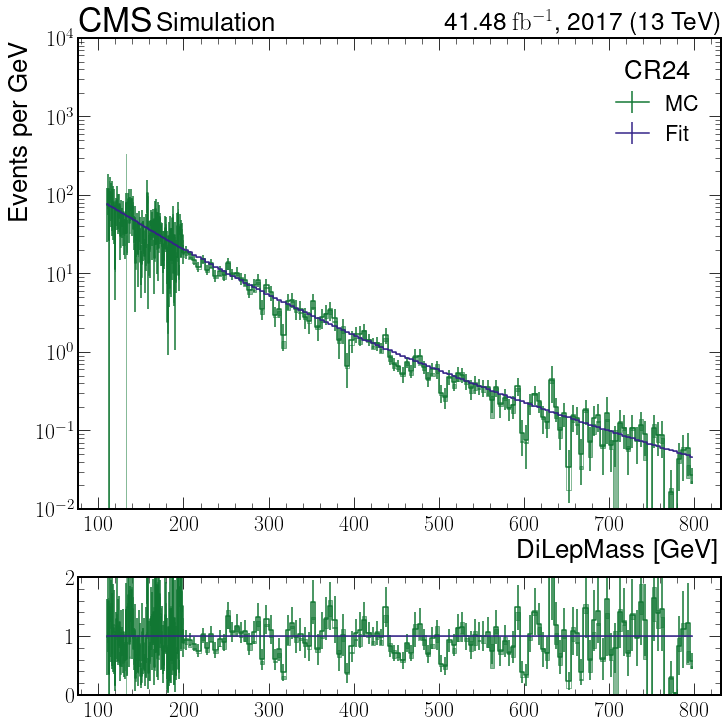

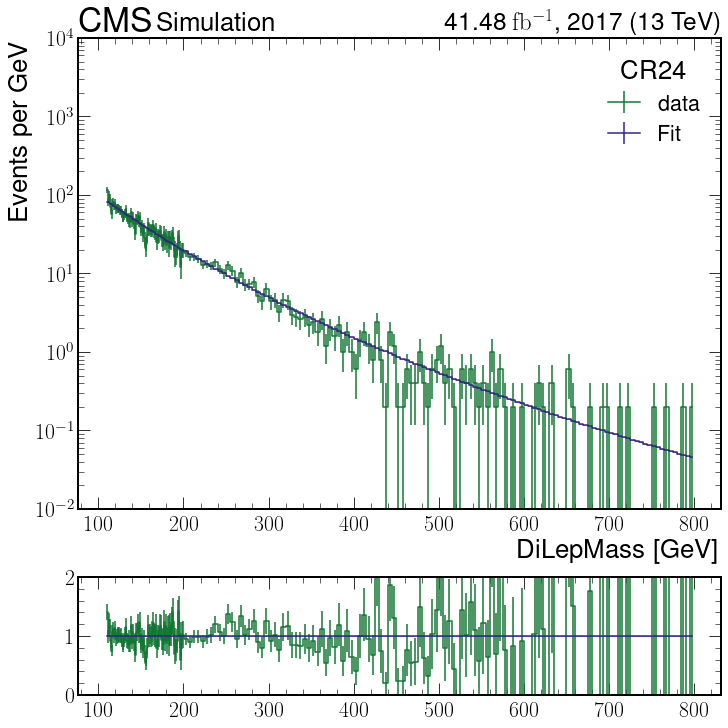

In [26]:
fit_stats = []
for reg in ['CR10', 'CR13', 'CR14', 'CR20', 'CR23', 'CR24']:
    print(reg)
    fit_stats.append(make_plot(reg, plot_dict_mc[reg], "MC"))
    fit_stats.append(make_plot(reg, plot_dict[reg], "data"))

In [27]:
def make_abcd(reg, plot_dict):
    def ufd(reg): return plot_dict[reg]['fit'].uncertainty_std_dev()
    A,B,C = ufd('CR{}0'.format(nJets)), ufd('CR{}3'.format(nJets)), ufd('CR{}4'.format(nJets))
    D = A*B/C
    return SysHist.from_ufloats(bins, D)

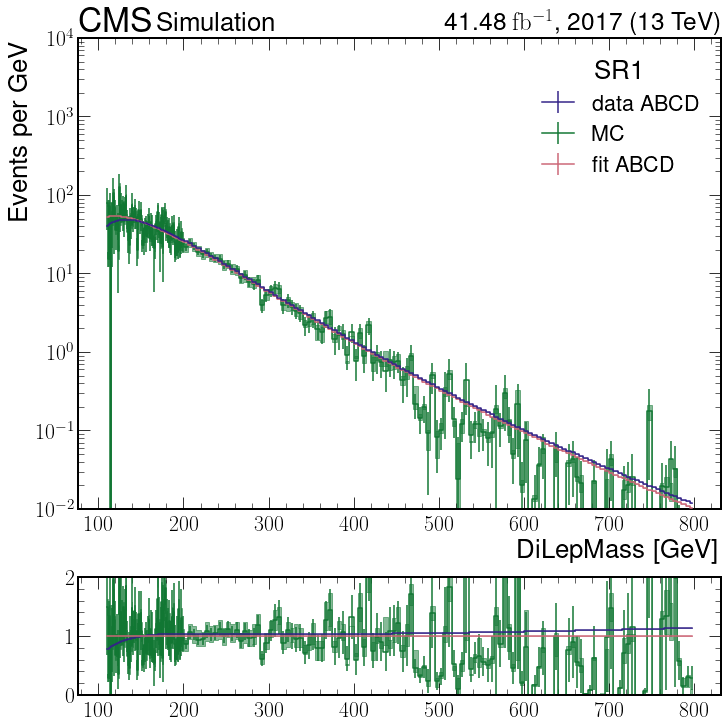

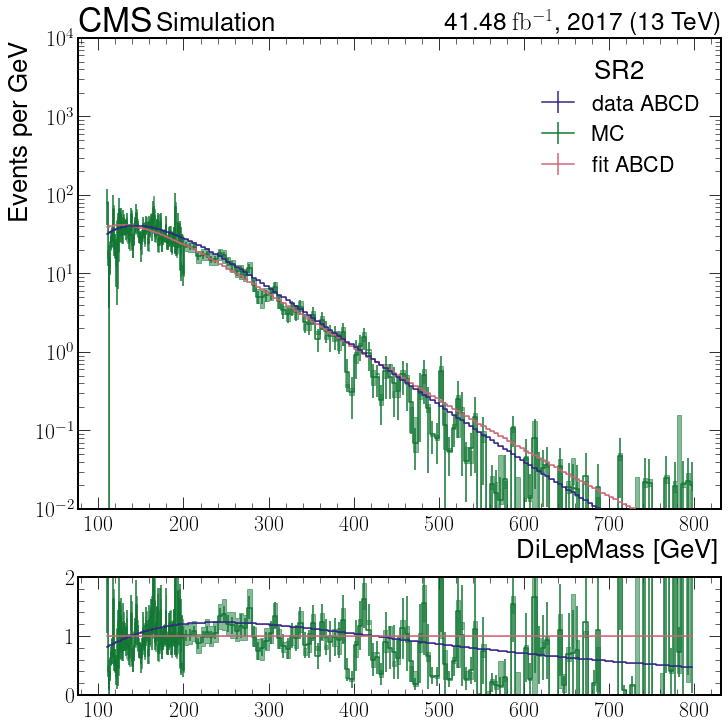

In [28]:
abcd_dict = {}
abcd_stats = []
#make abcd:
#A*B/C = D
for nJets in [1,2]:
    reg = 'SR{}'.format(nJets)
    ABCD = make_abcd(reg, plot_dict)
    abcd_dict[reg] = {"nom": ABCD.nominal, "std": ABCD.std, "bins": ABCD.bins.bin_edges}
    fig, ax, rax = ratio_plot_template(figsize=(10,10))
    ABCD.make_density_hist().draw(ax, color=color_cycle[0], label='data ABCD', zorder=4, error_scale=0)
    
    #mc background
    bck = make_sys(df[(df.type=='bck')], 'DiLepMass', reg)
    bck.make_density_hist().draw(ax, color=color_cycle[3], label='MC', zorder=2)
    ABCD_mc = make_abcd(reg, plot_dict_mc)
    ABCD_mc.make_density_hist().draw(ax, color=color_cycle[6], label='fit ABCD', zorder=3, error_scale=0)
    #ratio plot
    bck.calc_ratio(ABCD_mc.nominal).draw(rax, color=color_cycle[3])
    ABCD.calc_ratio(ABCD_mc.nominal).draw(rax, color=color_cycle[0], error_scale=0)
    ABCD_mc.calc_ratio(ABCD_mc.nominal).draw(rax, color=color_cycle[6], error_scale=0)
    rax.set_ylim(bottom=0, top=2)
    ax.set_yscale('log')
    ax.set_ylabel('Events per GeV')
    ax.set_xlabel('DiLepMass [GeV]')
    ax.set_ylim(bottom=1e-2, top=1e4)
    cms_format_fig(era, ax)
    ax.legend(title = '{}'.format(reg))
    fig.savefig('fits/abcd/{}_binning_density_{}_{}.png'.format(binning_type, era, reg))
    abcd_mc_chi2 = hist_chi2(bck, ABCD_mc, nDOF=4)
    abcd_data_chi2 = hist_chi2(bck, ABCD, nDOF=4)
    abcd_stats.append({'era': era, 'reg': reg, 'bck':np.sum(bck.nominal), 'bck_unc': np.sum(bck.std**2)**.5, 'ABCD mc': np.sum(ABCD_mc.nominal), 'ABCD data': np.sum(ABCD.nominal), 'MC chi2': abcd_mc_chi2, 'Data chi2': abcd_data_chi2})

In [29]:
import pandas as pd
df_stats = pd.DataFrame(abcd_stats)
df_stats.round(2)

,era,reg,bck,bck_unc,ABCD mc,ABCD data,MC chi2,Data chi2
0,2017,SR1,5677.58,187.34,5569.38,5485.12,1.36,1.46
1,2017,SR2,4808.44,110.75,4801.44,5244.90,2.62,3.04


In [30]:
print(df_stats.round(2).to_latex())

\begin{tabular}{lllrrrrrr}
\toprule
{} &   era &  reg &      bck &  bck\_unc &  ABCD mc &  ABCD data &  MC chi2 &  Data chi2 \\
\midrule
0 &  2017 &  SR1 &  5677.58 &   187.34 &  5569.38 &    5485.12 &     1.36 &       1.46 \\
1 &  2017 &  SR2 &  4808.44 &   110.75 &  4801.44 &    5244.90 &     2.62 &       3.04 \\
\bottomrule
\end{tabular}



In [31]:
fit_stats_df = pd.DataFrame(fit_stats)
fit_stats_df.round(2)

,era,reg,bck,bck_unc,ABCD mc,fit chi2,label
0,2017,CR10,39300.13,626.04,39300.13,1.44,MC
1,2017,CR10,37088.00,192.58,37088.00,0.93,data
2,2017,CR13,4166.30,141.07,4166.30,2.00,MC
3,2017,CR13,3703.00,60.85,3703.00,1.09,data
4,2017,CR14,29284.82,554.07,29284.82,1.14,MC
5,2017,CR14,25031.00,158.21,25031.00,1.20,data
6,2017,CR20,6760.41,322.26,6760.41,3.10,MC
7,2017,CR20,8093.00,89.96,8093.00,1.37,data
8,2017,CR23,3849.63,109.86,3849.63,1.59,MC
9,2017,CR23,3442.00,58.67,3442.00,1.05,data


In [32]:
print(fit_stats_df.round(2).to_latex())

\begin{tabular}{lllrrrrl}
\toprule
{} &   era &   reg &       bck &  bck\_unc &   ABCD mc &  fit chi2 & label \\
\midrule
0  &  2017 &  CR10 &  39300.13 &   626.04 &  39300.13 &      1.44 &    MC \\
1  &  2017 &  CR10 &  37088.00 &   192.58 &  37088.00 &      0.93 &  data \\
2  &  2017 &  CR13 &   4166.30 &   141.07 &   4166.30 &      2.00 &    MC \\
3  &  2017 &  CR13 &   3703.00 &    60.85 &   3703.00 &      1.09 &  data \\
4  &  2017 &  CR14 &  29284.82 &   554.07 &  29284.82 &      1.14 &    MC \\
5  &  2017 &  CR14 &  25031.00 &   158.21 &  25031.00 &      1.20 &  data \\
6  &  2017 &  CR20 &   6760.41 &   322.26 &   6760.41 &      3.10 &    MC \\
7  &  2017 &  CR20 &   8093.00 &    89.96 &   8093.00 &      1.37 &  data \\
8  &  2017 &  CR23 &   3849.63 &   109.86 &   3849.63 &      1.59 &    MC \\
9  &  2017 &  CR23 &   3442.00 &    58.67 &   3442.00 &      1.05 &  data \\
10 &  2017 &  CR24 &   5405.32 &   242.34 &   5405.32 &      1.48 &    MC \\
11 &  2017 &  CR24 &   5395.00 

In [33]:
with open('fits/limit_setting/abcd_dict_{}.pkl'.format(era), 'wb') as f:
    pickle.dump(abcd_dict, f, protocol=2)

In [34]:
abcd_dict

{'SR1': {'nom': array([4.07732356e+01, 4.15127810e+01, 4.22131642e+01, 4.28743686e+01,
         4.34964952e+01, 4.40797524e+01, 4.46244469e+01, 4.51309744e+01,
         4.55998115e+01, 4.60315071e+01, 4.64266747e+01, 4.67859854e+01,
         4.71101609e+01, 4.73999666e+01, 4.76562064e+01, 4.78797164e+01,
         4.80713597e+01, 4.82320221e+01, 4.83626068e+01, 4.84640309e+01,
         4.85372211e+01, 4.85831104e+01, 4.86026351e+01, 4.85967315e+01,
         4.85663332e+01, 4.85123691e+01, 4.84357609e+01, 4.83374213e+01,
         4.82182522e+01, 4.80791429e+01, 4.79209692e+01, 4.77445918e+01,
         4.75508556e+01, 4.73405884e+01, 4.71146003e+01, 4.68736832e+01,
         4.66186101e+01, 4.63501346e+01, 4.60689907e+01, 4.57758925e+01,
         4.54715341e+01, 4.51565893e+01, 4.48317117e+01, 4.44975348e+01,
         4.41546719e+01, 4.38037164e+01, 4.34452419e+01, 4.30798023e+01,
         4.27079321e+01, 4.23301468e+01, 4.19469432e+01, 4.15587993e+01,
         4.11661753e+01, 4.07695135e+